<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nltk

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import itertools
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import networkx as nx

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

In [5]:
def clean_df(df):
  df = pd.read_excel(df, skiprows=1)
  df = df.fillna('n/a')
  df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
  df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
  df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
  dates = []
  for index, row in df.iterrows():
    dates.append(to_date(row['Date']))
  df['Date'] = dates
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index('Date').sort_index()
  return df
df = clean_df('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx')
display(df.head())

,Extract,Notes,Notes2,About Adam Smith,Rep
Date,,,,,
2015-12-16,"It was on this very day, December 16, 1773, th...",n/a,n/a,"-, free market economics","Kevin John Cramer,\nRepublican Party"
2017-02-02,Adam Smith is spinning in his grave as he list...,"In other words, the price to be paid to make t...",n/a,-Adam Smith is spinning in his grave as he lis...,Edward John Markey\nDemocratic Party
2017-04-27,It is enough for people to inherit a house or ...,n/a,n/a,-“: You don’t want to have inherited wealth in...,Jamie Raskin\nDemocratic Party
2017-07-13,We can’t ignore the idea that even though Adam...,n/a,n/a,-‘‘The Wealth of Nations’’\n- fundamental prin...,n/a
2017-10-03,"At the hearing today, I heard my Republican co...",So let’s pay attention here. Adam Smith said t...,n/a,"-, ‘‘The Wealth of Nations,\n- “Maintain the s...",n/a


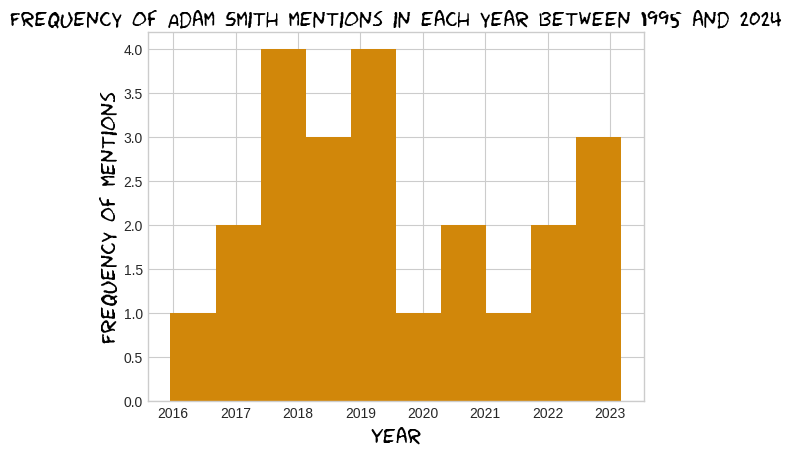

In [6]:
def create_histogram(df):
  #styles 'fast','fivethirtyeight'',',''seaborn-v0_8-whitegrid'
  plt.style.use('seaborn-v0_8-whitegrid')
  plt.hist(df.index, color='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.xlabel('Year', fontdict = font)
  plt.ylabel('Frequency of mentions', fontdict = font)
  plt.title('Frequency of Adam Smith mentions in each year between 1995 and 2024', fontdict = font)
  plt.show()

create_histogram(df)

In [7]:
def tokenize_df(df):
  tokens = [nltk.word_tokenize(row['Extract']) for index, row in df.iterrows()]
  return tokens

token_list = tokenize_df(df)
print(token_list[0][:10])

['It', 'was', 'on', 'this', 'very', 'day', ',', 'December', '16', ',']


In [8]:
def preprocess_tokens(list_of_lists):
  lower_tokens = [[t.lower() for t in list_of_tokens] for list_of_tokens in list_of_lists for t in list_of_tokens]
  alpha_only = [[t for t in token_list if t.isalpha()] for token_list in lower_tokens]
  no_stops = [[t for t in alpha_list if t not in nltk.corpus.stopwords.words('english')] for alpha_list in alpha_only]
  wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
  lemmatized = [[wordnet_lemmatizer.lemmatize(t) for t in no_stops_list] for no_stops_list in no_stops]
  return lemmatized

preprocessed = preprocess_tokens(token_list)
print(preprocessed[0][:10])

['day', 'december', 'patriot', 'boston', 'harbor', 'expressed', 'displeasure', 'foreign', 'power', 'influence']


In [9]:
def create_corpus(preprocessed_data):
  dictionary = Dictionary(preprocessed)
  corpus = [dictionary.doc2bow(article) for article in preprocessed]
  return dictionary, corpus

dictionary, corpus = create_corpus(preprocessed)
print(corpus[0][:10])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 3), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [10]:
import itertools
from collections import defaultdict
x = [[i[0] for i in j] for j in corpus]

pairs=[list(itertools.combinations(nested_list,2)) for nested_list in x]
catalogue_of_occurences = defaultdict(int)
repeating_pairs = {}
for list_of_pairs in pairs:
  for pair in list_of_pairs:
    catalogue_of_occurences[pair]+=1
y = list(catalogue_of_occurences.keys())
y[0]

(0, 1)

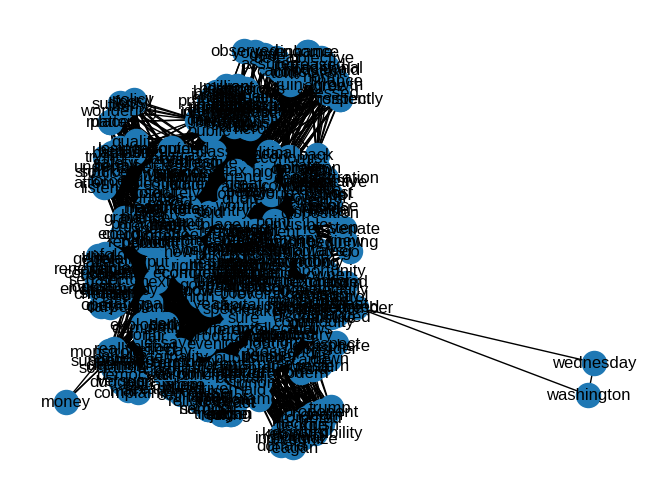

In [24]:
G = nx.Graph()
nodes = [i[0] for j in corpus for i in j]
G.add_nodes_from(nodes)
[G.add_edge(i[0],i[1]) for i in y]
for word_id in nodes:
  G.nodes[word_id]['label'] = dictionary.get(word_id)
labels = {}
for node, data in G.nodes(data=True):
  labels[node] = data.get('label')
nx.draw(G, with_labels=True, labels = labels)

In [12]:
def word_count_desc(corpus):
  total_word_count = collections.defaultdict(int)
  for word_id, word_count in itertools.chain.from_iterable(corpus):
      total_word_count[word_id] += word_count
  sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)
  return sorted_word_count

sorted_word_count = word_count_desc(corpus)
print(sorted_word_count[:10])

[(33, 2457), (0, 2318), (119, 1342), (17, 1196), (45, 1080), (104, 1047), (38, 1031), (135, 968), (23, 878), (166, 821)]


In [13]:
for word_id, word_count in sorted_word_count[:20]:
    print(dictionary.get(word_id), word_count)

smith 2457
adam 2318
wealth 1342
free 1196
country 1080
people 1047
would 1031
year 968
market 878
capitalism 821
nation 801
like 603
wrote 601
great 529
said 527
society 504
political 495
competition 456
quote 429
world 427


In [14]:
def calculate_weight_of_words(corpus):
  try:
    tfidf = TfidfModel(corpus)
    all_tfidf_weights = []
    i=1
    while tfidf[corpus[i]]:
      tfidf_weights = tfidf[corpus[i]]
      sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)
      all_tfidf_weights.append(sorted_tfidf_weights)
      i+=1
    return all_tfidf_weights
  except IndexError:
    return all_tfidf_weights

all_tfidf_weights = calculate_weight_of_words(corpus)
for term_id, weight in all_tfidf_weights[1][:20]:
  print(dictionary.get(term_id), weight)

commodity 0.4764702349667554
boston 0.3176468233111702
arbitrarily 0.1588234116555851
discriminated 0.1588234116555851
displeasure 0.1588234116555851
envisioned 0.1588234116555851
especially 0.1588234116555851
expressed 0.1588234116555851
felt 0.1588234116555851
foreign 0.1588234116555851
harbor 0.1588234116555851
influence 0.1588234116555851
opportunity 0.1588234116555851
owner 0.1588234116555851
participant 0.1588234116555851
practitioner 0.1588234116555851
tea 0.1588234116555851
teaching 0.1588234116555851
versed 0.1588234116555851
yes 0.1588234116555851


In [15]:
def add_extract_length(df):
  df['Extract length'] = df['Extract'].str.len()
  return df
df = add_extract_length(df)
display(df.head())

,Extract,Notes,Notes2,About Adam Smith,Rep,Extract length
Date,,,,,,
2015-12-16,"It was on this very day, December 16, 1773, th...",n/a,n/a,"-, free market economics","Kevin John Cramer,\nRepublican Party",565
2017-02-02,Adam Smith is spinning in his grave as he list...,"In other words, the price to be paid to make t...",n/a,-Adam Smith is spinning in his grave as he lis...,Edward John Markey\nDemocratic Party,410
2017-04-27,It is enough for people to inherit a house or ...,n/a,n/a,-“: You don’t want to have inherited wealth in...,Jamie Raskin\nDemocratic Party,856
2017-07-13,We can’t ignore the idea that even though Adam...,n/a,n/a,-‘‘The Wealth of Nations’’\n- fundamental prin...,n/a,240
2017-10-03,"At the hearing today, I heard my Republican co...",So let’s pay attention here. Adam Smith said t...,n/a,"-, ‘‘The Wealth of Nations,\n- “Maintain the s...",n/a,554


In [16]:
def check_sentiment(df):
  polarity = []
  subjectivity = []
  for index, row in df.iterrows():
    sentiment = TextBlob(row['Extract'])
    polarity.append(sentiment.polarity)
    subjectivity.append(sentiment.subjectivity)
  df['Polarity'] = polarity
  df['Subjectivity'] = subjectivity
  return df

df_sentiments = check_sentiment(df)
display(df_sentiments.head())

,Extract,Notes,Notes2,About Adam Smith,Rep,Extract length,Polarity,Subjectivity
Date,,,,,,,,
2015-12-16,"It was on this very day, December 16, 1773, th...",n/a,n/a,"-, free market economics","Kevin John Cramer,\nRepublican Party",565,0.184375,0.578125
2017-02-02,Adam Smith is spinning in his grave as he list...,"In other words, the price to be paid to make t...",n/a,-Adam Smith is spinning in his grave as he lis...,Edward John Markey\nDemocratic Party,410,-0.072727,0.404242
2017-04-27,It is enough for people to inherit a house or ...,n/a,n/a,-“: You don’t want to have inherited wealth in...,Jamie Raskin\nDemocratic Party,856,0.039103,0.518590
2017-07-13,We can’t ignore the idea that even though Adam...,n/a,n/a,-‘‘The Wealth of Nations’’\n- fundamental prin...,n/a,240,0.400000,0.800000
2017-10-03,"At the hearing today, I heard my Republican co...",So let’s pay attention here. Adam Smith said t...,n/a,"-, ‘‘The Wealth of Nations,\n- “Maintain the s...",n/a,554,0.153000,0.324833


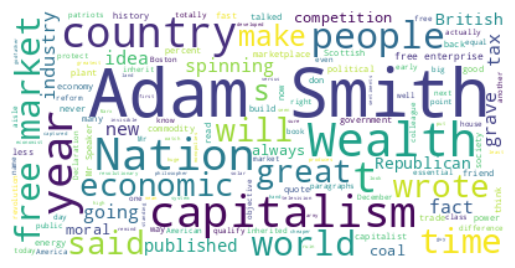

In [17]:
def word_cloud(df):
  text = " "
  for index, row in df.iterrows():
    text += " "
    text += row['Extract']
  word_cloud = WordCloud(background_color='white').generate(text)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()
word_cloud(df)

In [18]:
def bow_with_ngrams(df):
  my_stop_words = list(ENGLISH_STOP_WORDS.union(['adam', 'smith', 'speaker', 'don', 'seen', 'smith' 'wrote', 'actually', 'mr speaker', 'sure', 'said']))
  vect = CountVectorizer(ngram_range=(1, 2), max_features=200, stop_words=my_stop_words)
  vect.fit(df.Extract)
  X_extract = vect.transform(df.Extract)
  X_df=pd.DataFrame(X_extract.toarray(), columns=vect.get_feature_names_out())
  return X_df
display(bow_with_ngrams(df).columns)
bow_bigrams = bow_with_ngrams(df).head()
print(bow_bigrams)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['mr'] not in stop_words.
  warnings.warn(


Index(['1776', 'aisle', 'america', 'american', 'army', 'army monopolies',
       'big', 'book', 'boston', 'british',
       ...
       'watch standing', 'way', 'wealth', 'wealth nations', 'world', 'wrote',
       'wrote wealth', 'year', 'year 1776', 'years'],
      dtype='object', length=200)

   1776  aisle  america  american  army  army monopolies  big  book  boston  \
0     0      0        0         0     0                0    0     0       2   
1     0      0        0         0     0                0    0     0       0   
2     0      1        0         0     0                0    1     0       0   
3     1      0        0         0     0                0    0     1       0   
4     0      0        0         0     0                0    0     0       0   

   british  ...  watch standing  way  wealth  wealth nations  world  wrote  \
0        0  ...               0    0       0               0      0      0   
1        0  ...               0    0       0               0      0      0   
2        0  ...               0    1       3               0      0      0   
3        0  ...               0    0       1               1      1      1   
4        3  ...               0    0       1               1      1      0   

   wrote wealth  year  year 1776  years  
0             

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['mr'] not in stop_words.
  warnings.warn(
